# Entrainement du modèle

In [1]:
import pandas as pd
from skimage import io, color
from skimage.feature import hog
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
import numpy as np
from PIL import Image
import os
import joblib

def load_images_and_labels(image_dir, label_dir):
    data = []
    labels = []
    columns = ['x1', 'y1', 'x2', 'y2', 'label']

    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            image_path = os.path.join(image_dir, filename)
            csv_path = os.path.join(label_dir, filename[:-4] + ".csv")
            
            if not os.path.exists(csv_path):
                continue

            image = io.imread(image_path)
            if len(image.shape) > 2:
                image = color.rgb2gray(image)  # Convertir en niveaux de gris pour HOG

            df = pd.read_csv(csv_path, header=None, names=columns)
            for _, row in df.iterrows():
                label = row['label'].strip()
                if label == 'ff':
                    continue  # Ignorer les labels 'ff'
                
                if label == 'empty':
                    # Diviser l'image en 9 sous-images et utiliser chaque sous-image pour les cas 'empty'
                    height, width = image.shape
                    sub_images = [
                        image[:height//3, :width//3],
                        image[:height//3, width//3:2*width//3],
                        image[:height//3, 2*width//3:],
                        image[height//3:2*height//3, :width//3],
                        image[height//3:2*height//3, 2*width//3:],
                        image[2*height//3:, :width//3],
                    ]
                    for sub_image in sub_images:
                        sub_image_resized = Image.fromarray(sub_image).resize((100, 100))
                        hog_features = hog(np.array(sub_image_resized),orientations=16, pixels_per_cell=(8, 8),
                                           cells_per_block=(2, 2), visualize=False, feature_vector=True)
                        data.append(hog_features)
                        labels.append(label)  # Utiliser le label 'empty' pour chaque sous-image
                else:
                    x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])
                    if x1 >= x2 or y1 >= y2 or x1 < 0 or y1 < 0 or x2 > image.shape[1] or y2 > image.shape[0]:
                        continue
                    roi = image[y1:y2, x1:x2]
                    if roi.size == 0:
                        continue
                    roi_resized = Image.fromarray(roi).resize((100, 100))  # S'assurer que le redimensionnement est correct
                    roi_array = np.array(roi_resized)
                    hog_features = hog(roi_array,orientations=16, pixels_per_cell=(8, 8),
                                           cells_per_block=(2, 2), visualize=False, feature_vector=True)
                    data.append(hog_features)
                    labels.append(label)  # Utiliser le label spécifique du panneau

    return np.array(data, dtype='float64'), np.array(labels)  # Les labels seront convertis séparément

# Chemins vers les dossiers d'images et de labels
image_dir = 'train/images2'
label_dir = 'train/labels2'

# Charger les données
features, target = load_images_and_labels(image_dir, label_dir)

# Encoder les labels
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Création et entraînement du SVM avec probability=True
clf = svm.SVC(kernel='linear', probability=True)
clf.fit(features, target_encoded)  # Utiliser les labels encodés
print("Le modèle SVM a été entraîné.")

Le modèle SVM a été entraîné.


## Détection parfois réussite sur les feux, à revoir

In [2]:
from PIL import Image, ImageDraw
import numpy as np
from skimage.feature import hog
from skimage.transform import pyramid_gaussian

# Fonction pour préparer les données HOG avec les coordonnées
def prepare_data(image, box):
    x1, y1, x2, y2 = box
    patch = image.crop((x1, y1, x2, y2))
    patch_resized = patch.resize((100, 100))  # Redimensionner à la taille d'entrée pour HOG
    patch_array = np.array(patch_resized)
    # Convertir l'image en niveaux de gris si elle est en couleur
    if patch_array.ndim == 3:
        patch_array = np.mean(patch_array, axis=2)
    hog_features = hog(patch_array, orientations=16, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False, feature_vector=True)
    return hog_features

# Fonction pour faire glisser la fenêtre
def sliding_window(image, step_size, window_size):
    for y in range(0, image.height - window_size[1], step_size):
        for x in range(0, image.width - window_size[0], step_size):
            yield (x, y, x + window_size[0], y + window_size[1])

# Fonction de détection
def detect_with_window(image, win_size, step_size, confidence_threshold, clf, label_encoder, draw):
    detections = []
    for (i, resized) in enumerate(pyramid_gaussian(np.array(image), downscale=1.5)):
        resized_image = Image.fromarray((resized * 255).astype(np.uint8))
        # Si l'image redimensionnée est plus petite que la fenêtre, on arrête
        if resized_image.height < win_size[1] or resized_image.width < win_size[0]:
            break

        # Parcourir l'image avec la fenêtre glissante
        for (x1, y1, x2, y2) in sliding_window(resized_image, step_size, win_size):
            if x2 > resized_image.width or y2 > resized_image.height:
                continue

            # Préparer les données HOG pour la fenêtre courante
            hog_features = prepare_data(resized_image, (x1, y1, x2, y2))
            probabilities = clf.predict_proba([hog_features])[0]
            max_proba = np.max(probabilities)
            
            if max_proba >= confidence_threshold:
                prediction = np.argmax(probabilities)
                predicted_label = label_encoder.inverse_transform([prediction])[0]

                # Ignorer les prédictions avec le label 'empty'
                if predicted_label == 'empty':
                    continue

                # Stocker la prédiction et sa probabilité
                detections.append((max_proba, predicted_label, i, x1, y1, x2, y2))
                
                # Dessiner un rectangle autour de la détection
                draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=2)
    
    return detections

# Fonction principale pour détecter les panneaux dans une image
def detect_signs_in_image(image_path, clf, label_encoder, confidence_threshold=0.4):
    # Charger l'image
    image = Image.open(image_path).convert('RGB')
    draw = ImageDraw.Draw(image)

    # Paramètres HOG utilisés lors de l'entraînement
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)

    # Détection avec des rectangles 100x200
    detections_100x200 = detect_with_window(image, (100, 200), 32, confidence_threshold, clf, label_encoder, draw)

    # Détection avec des carrés 200x200
    detections_200x200 = detect_with_window(image, (200, 200), 32, confidence_threshold, clf, label_encoder, draw)

    # Combiner toutes les détections
    all_detections = detections_100x200 + detections_200x200

    # Trier les détections par probabilité décroissante
    all_detections = sorted(all_detections, key=lambda x: x[0], reverse=True)

    # Afficher les 5 meilleures prédictions pour chaque taille de fenêtre
    print("Les 5 meilleures prédictions avec des rectangles 100x200 :")
    for detection in detections_100x200[:5]:
        print(f"Panneau détecté: {detection[1]}, Confiance: {detection[0]:.2f}, Échelle: {detection[2]}, Position: ({detection[3]}, {detection[4]})")

    print("\nLes 5 meilleures prédictions avec des carrés 200x200 :")
    for detection in detections_200x200[:5]:
        print(f"Panneau détecté: {detection[1]}, Confiance: {detection[0]:.2f}, Échelle: {detection[2]}, Position: ({detection[3]}, {detection[4]})")

    # Afficher l'image avec les rectangles
    image.show()

    # Obtenir la détection avec la meilleure précision
    if all_detections:
        best_detection = all_detections[0]
        best_label = best_detection[1]
        result_phrase = f"L'image contient à priori le panneau {best_label}"
        #print(result_phrase)
    else:
        result_phrase = "Aucun panneau détecté avec une confiance suffisante."
        #print(result_phrase)

    print("Détection terminée")
    return result_phrase, all_detections

# Exemple d'utilisation
# Assurez-vous que `clf` et `label_encoder` sont déjà entraînés et disponibles
# clf = <votre modèle entraîné>
# label_encoder = <votre label encoder>

image_path = 'train/images/0008.jpg'
result_phrase, detections = detect_signs_in_image(image_path, clf, label_encoder)


Les 5 meilleures prédictions avec des rectangles 100x200 :
Panneau détecté: fvert, Confiance: 0.47, Échelle: 0, Position: (416, 0)
Panneau détecté: fvert, Confiance: 0.52, Échelle: 0, Position: (768, 0)
Panneau détecté: fvert, Confiance: 0.50, Échelle: 0, Position: (800, 0)
Panneau détecté: fvert, Confiance: 0.44, Échelle: 0, Position: (128, 96)
Panneau détecté: fvert, Confiance: 0.48, Échelle: 0, Position: (448, 96)

Les 5 meilleures prédictions avec des carrés 200x200 :
Panneau détecté: forange, Confiance: 0.56, Échelle: 0, Position: (608, 32)
Panneau détecté: fvert, Confiance: 0.66, Échelle: 0, Position: (736, 32)
Panneau détecté: fvert, Confiance: 0.55, Échelle: 0, Position: (736, 64)
Panneau détecté: frouge, Confiance: 0.42, Échelle: 0, Position: (384, 96)
Panneau détecté: frouge, Confiance: 0.42, Échelle: 0, Position: (608, 96)
Détection terminée


In [3]:
from PIL import Image, ImageDraw
import numpy as np
from skimage.feature import hog
from skimage.transform import pyramid_gaussian
from collections import Counter
from joblib import Parallel, delayed

# Fonction pour préparer les données HOG avec les coordonnées
def prepare_data(image, box):
    x1, y1, x2, y2 = box
    patch = image.crop((x1, y1, x2, y2))
    patch_resized = patch.resize((100, 100))  # Redimensionner à la taille d'entrée pour HOG
    patch_array = np.array(patch_resized)
    # Convertir l'image en niveaux de gris si elle est en couleur
    if patch_array.ndim == 3:
        patch_array = np.mean(patch_array, axis=2)
    hog_features = hog(patch_array, orientations=16, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False, feature_vector=True)
    return hog_features

# Fonction pour faire glisser la fenêtre
def sliding_window(image, step_size, window_size):
    for y in range(0, image.height - window_size[1], step_size):
        for x in range(0, image.width - window_size[0], step_size):
            yield (x, y, x + window_size[0], y + window_size[1])

# Fonction de détection pour une seule fenêtre
def detect_single_window(image, box, clf, label_encoder, confidence_threshold):
    hog_features = prepare_data(image, box)
    probabilities = clf.predict_proba([hog_features])[0]
    max_proba = np.max(probabilities)
    if max_proba >= confidence_threshold:
        prediction = np.argmax(probabilities)
        predicted_label = label_encoder.inverse_transform([prediction])[0]
        if predicted_label != 'empty':
            return max_proba, predicted_label, box
    return None

# Fonction de détection
def detect_with_window(image, win_size, step_size, confidence_threshold, clf, label_encoder, draw):
    detections = []
    for (i, resized) in enumerate(pyramid_gaussian(np.array(image), downscale=1.5)):
        resized_image = Image.fromarray((resized * 255).astype(np.uint8))
        # Si l'image redimensionnée est plus petite que la fenêtre, on arrête
        if resized_image.height < win_size[1] or resized_image.width < win_size[0]:
            break

        # Parcourir l'image avec la fenêtre glissante
        boxes = list(sliding_window(resized_image, step_size, win_size))
        results = Parallel(n_jobs=-1)(delayed(detect_single_window)(resized_image, box, clf, label_encoder, confidence_threshold) for box in boxes)
        results = [r for r in results if r is not None]

        for max_proba, predicted_label, (x1, y1, x2, y2) in results:
            # Ajuster les coordonnées à l'échelle originale
            scale_factor = 1.5 ** i
            original_x1 = int(x1 * scale_factor)
            original_y1 = int(y1 * scale_factor)
            original_x2 = int(x2 * scale_factor)
            original_y2 = int(y2 * scale_factor)

            # Stocker la prédiction et sa probabilité
            detections.append((max_proba, predicted_label, i, original_x1, original_y1, original_x2, original_y2))
                
            # Dessiner un rectangle autour de la détection
            draw.rectangle([(original_x1, original_y1), (original_x2, original_y2)], outline="red", width=2)
    
    return detections

# Fonction principale pour détecter les panneaux dans une image
def detect_signs_in_image(image_path, clf, label_encoder, confidence_threshold=0.4):
    # Charger l'image
    image = Image.open(image_path).convert('RGB')
    draw = ImageDraw.Draw(image)

    # Détection avec des rectangles 100x200
    detections_100x200 = detect_with_window(image, (100, 200), 32, confidence_threshold, clf, label_encoder, draw)

    # Détection avec des carrés 200x200
    detections_200x200 = detect_with_window(image, (200, 200), 32, confidence_threshold, clf, label_encoder, draw)

    # Détection avec des rectangles 50x100
    detections_50x100 = detect_with_window(image, (50, 100), 32, confidence_threshold, clf, label_encoder, draw)

    # Combiner toutes les détections
    all_detections = detections_100x200 + detections_200x200 + detections_50x100

    # Trier les détections par probabilité décroissante
    all_detections = sorted(all_detections, key=lambda x: x[0], reverse=True)

    # Afficher les 5 meilleures prédictions pour chaque taille de fenêtre
    print("Les 5 meilleures prédictions avec des rectangles 100x200 :")
    for detection in detections_100x200[:5]:
        print(f"Panneau détecté: {detection[1]}, Confiance: {detection[0]:.2f}, Échelle: {detection[2]}, Position: ({detection[3]}, {detection[4]})")

    print("\nLes 5 meilleures prédictions avec des carrés 200x200 :")
    for detection in detections_200x200[:5]:
        print(f"Panneau détecté: {detection[1]}, Confiance: {detection[0]:.2f}, Échelle: {detection[2]}, Position: ({detection[3]}, {detection[4]})")

    print("\nLes 5 meilleures prédictions avec des rectangles 50x100 :")
    for detection in detections_50x100[:5]:
        print(f"Panneau détecté: {detection[1]}, Confiance: {detection[0]:.2f}, Échelle: {detection[2]}, Position: ({detection[3]}, {detection[4]})")

    # Afficher l'image avec les rectangles
    image.show()

    # Obtenir la détection avec la meilleure précision
    if all_detections:
        best_detection = all_detections[0]
        best_label = best_detection[1]
        
        # Obtenir la détection qui apparait le plus de fois
        labels = [detection[1] for detection in all_detections]
        most_common_label, most_common_count = Counter(labels).most_common(1)[0]
        
        result_phrase = (f"L'image contient à priori le panneau {best_label} "
                         f"avec la plus grande confiance ({best_detection[0]:.2f}). "
                         f"Le panneau le plus fréquemment détecté est {most_common_label} "
                         f"apparu {most_common_count} fois.")
        print(result_phrase)
    else:
        result_phrase = "Aucun panneau détecté avec une confiance suffisante."
        print(result_phrase)

    print("Détection terminée")
    return result_phrase, all_detections

# Exemple d'utilisation
# Assurez-vous que `clf` et `label_encoder` sont déjà entraînés et disponibles
# clf = <votre modèle entraîné>
# label_encoder = <votre label encoder>

image_path = 'train/images/0312.jpg'
result_phrase, detections = detect_signs_in_image(image_path, clf, label_encoder)



Les 5 meilleures prédictions avec des rectangles 100x200 :
Panneau détecté: forange, Confiance: 0.42, Échelle: 0, Position: (160, 0)
Panneau détecté: fvert, Confiance: 0.44, Échelle: 0, Position: (256, 0)
Panneau détecté: fvert, Confiance: 0.60, Échelle: 0, Position: (448, 0)
Panneau détecté: fvert, Confiance: 0.42, Échelle: 0, Position: (704, 0)
Panneau détecté: fvert, Confiance: 0.54, Échelle: 0, Position: (896, 0)

Les 5 meilleures prédictions avec des carrés 200x200 :
Panneau détecté: fvert, Confiance: 0.56, Échelle: 0, Position: (384, 0)
Panneau détecté: frouge, Confiance: 0.53, Échelle: 0, Position: (640, 32)
Panneau détecté: frouge, Confiance: 0.48, Échelle: 0, Position: (672, 32)
Panneau détecté: frouge, Confiance: 0.60, Échelle: 0, Position: (96, 64)
Panneau détecté: forange, Confiance: 0.40, Échelle: 0, Position: (352, 96)

Les 5 meilleures prédictions avec des rectangles 50x100 :
Panneau détecté: fvert, Confiance: 0.57, Échelle: 0, Position: (224, 0)
Panneau détecté: fvert, 

In [4]:
from PIL import Image, ImageDraw
import numpy as np
from skimage.feature import hog
from skimage.transform import pyramid_gaussian
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage import measure
from skimage.draw import polygon_perimeter
from joblib import Parallel, delayed

# Fonction pour préparer les données HOG avec les coordonnées
def prepare_data(image, box):
    x1, y1, x2, y2 = box
    patch = image.crop((x1, y1, x2, y2))
    patch_resized = patch.resize((100, 100))  # Redimensionner à la taille d'entrée pour HOG
    patch_array = np.array(patch_resized)
    # Convertir l'image en niveaux de gris si elle est en couleur
    if patch_array.ndim == 3:
        patch_array = np.mean(patch_array, axis=2)
    hog_features = hog(patch_array, orientations=16, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False, feature_vector=True)
    return hog_features

# Fonction pour détecter les contours et les formes géométriques
def detect_shapes(image):
    gray = rgb2gray(image)
    blurred = gaussian(gray, sigma=1)
    thresh = blurred > 0.5
    labeled = measure.label(thresh)
    regions = measure.regionprops(labeled)

    shapes = []
    for region in regions:
        minr, minc, maxr, maxc = region.bbox
        width = maxc - minc
        height = maxr - minr
        area = region.area
        perimeter = region.perimeter

        if perimeter == 0:
            continue

        # Calculer la circularité pour détecter les cercles
        circularity = 4 * np.pi * (area / (perimeter * perimeter))

        if width > 20 and height > 20:  # Filtrer les petites régions bruitées
            if 0.8 <= circularity <= 1.2:
                shape = "circle"
            elif abs(width - height) < 10:
                shape = "rectangle"  # Approximativement carré
            elif width > 1.2 * height or height > 1.2 * width:
                shape = "rectangle"
            else:
                # Détection de triangle par approximation du polygone
                coords = region.coords
                approx = measure.approximate_polygon(coords, tolerance=2.5)
                if len(approx) == 4:
                    shape = "triangle"
                else:
                    shape = "unidentified"
            shapes.append((shape, (minc, minr, maxc, maxr)))

    return shapes

# Fonction principale pour détecter les panneaux dans une image
def detect_signs_in_image(image_path, clf, label_encoder, confidence_threshold=0.4):
    # Charger l'image
    image = Image.open(image_path).convert('RGB')
    image_array = np.array(image)
    draw = ImageDraw.Draw(image)

    # Détection des formes géométriques
    shapes = detect_shapes(image_array)

    # Liste pour stocker les détections finales
    all_detections = []

    for (shape, bbox) in shapes:
        x1, y1, x2, y2 = bbox
        box = (x1, y1, x2, y2)
        hog_features = prepare_data(image, box)
        probabilities = clf.predict_proba([hog_features])[0]
        max_proba = np.max(probabilities)

        if max_proba >= confidence_threshold:
            prediction = np.argmax(probabilities)
            predicted_label = label_encoder.inverse_transform([prediction])[0]
            all_detections.append((max_proba, predicted_label, x1, y1, x2, y2))
            draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=2)

    # Afficher les détections sur l'image
    image.show()

    # Préparer les résultats avec les pourcentages de confiance les plus élevés
    detections_summary = {}
    for detection in all_detections:
        proba, label, x1, y1, x2, y2 = detection
        if label not in detections_summary or proba > detections_summary[label]:
            detections_summary[label] = proba

    # Trier les détections par confiance décroissante
    sorted_detections = sorted(detections_summary.items(), key=lambda x: x[1], reverse=True)

    # Afficher le panneau avec le pourcentage le plus élevé (en ignorant 'empty' si c'est le plus probable)
    if sorted_detections:
        best_label, best_proba = sorted_detections[0]
        if best_label == 'empty' and len(sorted_detections) > 1:
            best_label, best_proba = sorted_detections[1]
        result_phrase = f"Cette image contient à priori ce panneau : {best_label} à {best_proba * 100:.2f}%"
    else:
        result_phrase = "Aucun panneau détecté avec une confiance suffisante."

    print(result_phrase)
    print("Détails des détections :")
    for label, proba in sorted_detections:
        print(f"{label} à {proba * 100:.2f}%")

    print("Détection terminée")
    return result_phrase, all_detections



image_path = 'train/images/0005.jpg'
result_phrase, detections = detect_signs_in_image(image_path, clf, label_encoder)


Cette image contient à priori ce panneau : frouge à 60.41%
Détails des détections :
empty à 98.55%
frouge à 60.41%
fvert à 50.14%
Détection terminée


# Code final

In [5]:
# Fonction pour préparer les données HOG avec les coordonnées
def prepare_data(image, box):
    x1, y1, x2, y2 = box
    patch = image.crop((x1, y1, x2, y2))
    patch_resized = patch.resize((100, 100))  # Redimensionner à 100x100 pour correspondre au modèle entraîné
    patch_array = np.array(patch_resized)
    # Convertir l'image en niveaux de gris si elle est en couleur
    if patch_array.ndim == 3:
        patch_array = np.mean(patch_array, axis=2)
    hog_features = hog(patch_array, orientations=16, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False, feature_vector=True)
    return hog_features

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [6]:
def does_box_enclose(box1, box2):
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2
    return x1_1 <= x1_2 and y1_1 <= y1_2 and x2_1 >= x2_2 and y2_1 >= y2_2

# Fonction pour vérifier si une boîte englobante en englobe une autre
def does_box_enclose(box1, box2):
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2
    return x1_1 <= x1_2 and y1_1 <= y1_2 and x2_1 >= x2_2 and y2_1 >= y2_2

# Fonction pour vérifier si deux boîtes englobantes sont trop proches
def are_boxes_too_close(box1, box2, threshold=20):
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2
    return abs(x1_1 - x1_2) < threshold and abs(y1_1 - y1_2) < threshold and \
           abs(x2_1 - x2_2) < threshold and abs(y2_1 - y2_2) < threshold

# Fonction pour unifier deux boîtes
def unify_boxes(box1, box2):
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2
    unified_x1 = min(x1_1, x1_2)
    unified_y1 = min(y1_1, y1_2)
    unified_x2 = max(x2_1, x2_2)
    unified_y2 = max(y2_1, y2_2)
    return (unified_x1, unified_y1, unified_x2, unified_y2)



def is_close(bbox1, bbox2, threshold=20):
    label1, x1_1, y1_1, x2_1, y2_1, _ = bbox1
    label2, x1_2, y1_2, x2_2, y2_2, _ = bbox2
    if label1 != label2:
        return False
    if (abs(x1_1 - x1_2) < threshold or abs(y1_1 - y1_2) < threshold or
        abs(x2_1 - x2_2) < threshold or abs(y2_1 - y2_2) < threshold):
        return True
    return False


def is_contained(inner_box, outer_box):
    ix1, iy1, ix2, iy2 = inner_box
    ox1, oy1, ox2, oy2 = outer_box
    return ix1 >= ox1 and iy1 >= oy1 and ix2 <= ox2 and iy2 <= oy2

In [7]:
from PIL import Image, ImageDraw
import numpy as np
from skimage.feature import hog
from skimage.transform import pyramid_gaussian
from collections import defaultdict
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from skimage import io, color, measure, filters, morphology, feature
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC


# Fonction pour faire glisser la fenêtre
def sliding_window(image, step_size, window_size):
    for y in range(0, image.height - window_size[1] + 1, step_size):
        for x in range(0, image.width - window_size[0] + 1, step_size):
            yield (x, y, x + window_size[0], y + window_size[1])

# Fonction de détection pour une seule fenêtre
def detect_single_window(image, box, clf, label_encoder, confidence_threshold):
    hog_features = prepare_data(image, box)
    probabilities = clf.predict_proba([hog_features])[0]
    max_proba = np.max(probabilities)
    if max_proba >= confidence_threshold:
        prediction = np.argmax(probabilities)
        predicted_label = label_encoder.inverse_transform([prediction])[0]
        if predicted_label != 'empty':
            return max_proba, predicted_label, box
    return None
    


# Fonction de détection avec une fenêtre de taille fixe
def detect_with_fixed_window(image, win_size, step_size, confidence_threshold, clf, label_encoder):
    detections = []
    for (i, resized) in enumerate(pyramid_gaussian(np.array(image), downscale=1.5, max_layer=4)):
        resized_image = Image.fromarray((resized * 255).astype(np.uint8))
        boxes = list(sliding_window(resized_image, step_size, win_size))
        results = Parallel(n_jobs=-1)(delayed(detect_single_window)(resized_image, box, clf, label_encoder, confidence_threshold) for box in boxes)
        results = [r for r in results if r is not None]

        for max_proba, predicted_label, (x1, y1, x2, y2) in results:
            scale_factor = 1.5 ** i
            original_x1 = int(x1 * scale_factor)
            original_y1 = int(y1 * scale_factor)
            original_x2 = int(x2 * scale_factor)
            original_y2 = int(y2 * scale_factor)
            detections.append((max_proba, predicted_label, original_x1, original_y1, original_x2, original_y2))

    # Appliquer la suppression non maximale (NMS) aux détections
    final_detections = non_max_suppression(detections, iou_threshold=0.3)

    return final_detections


# Fonction de suppression non maximale
def non_max_suppression(detections, iou_threshold=0.3):
    if len(detections) == 0:
        return []

    # Trier les détections par score de confiance
    detections = sorted(detections, key=lambda x: x[0], reverse=True)
    final_detections = []

    while len(detections) > 0:
        best_detection = detections.pop(0)
        final_detections.append(best_detection)

        detections = [det for det in detections if calculate_iou(best_detection[2:], det[2:]) < iou_threshold]

    return final_detections


def detect_signs_in_image(image_path, clf, label_encoder, confidence_threshold=0.4):
    # Charger l'image
    image = Image.open(image_path).convert('RGB')

    # Détection avec des carrés 64x64
    detections_64x64 = detect_with_fixed_window(image, (64, 64), 64, confidence_threshold, clf, label_encoder)

    # Stocker les résultats
    bboxes = []
    bboxes_confidences = defaultdict(list)

    for max_proba, predicted_label, x1, y1, x2, y2 in detections_64x64:
        bboxes.append(((x1, y1, x2, y2), predicted_label))
        bboxes_confidences[(x1, y1, x2, y2)].append(max_proba)
    
    # Filtrer les détections avec une confiance supérieure à 65%
    filtered_bboxes = [(bbox, label) for bbox, label in bboxes if max(bboxes_confidences[bbox]) >= 0.65]

    # Fusion des boîtes et reclassification
    final_bboxes_filtered = []
    for bbox, label in filtered_bboxes:
        merged = False
        for i, (existing_bbox, existing_label) in enumerate(final_bboxes_filtered):
            if existing_label == label and (does_box_enclose(existing_bbox, bbox) or does_box_enclose(bbox, existing_bbox) or are_boxes_too_close(existing_bbox, bbox)):
                # Unifier les boîtes
                unified_box = unify_boxes(existing_bbox, bbox)
                final_bboxes_filtered[i] = (unified_box, label)
                merged = True
                break
        if not merged:
            final_bboxes_filtered.append((bbox, label))

    # Refaire la classification sur les boîtes unifiées
    final_bboxes = []
    for bbox, label in final_bboxes_filtered:
        reclassified = detect_single_window(image, bbox, clf, label_encoder, confidence_threshold)
        if reclassified:
            max_proba, predicted_label, _ = reclassified
            final_bboxes.append((bbox, predicted_label, max_proba))

    # Trouver la boîte avec la plus grande valeur de prédiction
    if final_bboxes:
        best_bbox = max(final_bboxes, key=lambda item: item[2])
        best_label = best_bbox[1]
        result_phrase = f"L'image contient à priori le panneau {best_label} avec la plus grande valeur de confiance ({best_bbox[2]*100:.2f}%)."
    else:
        result_phrase = "Aucun panneau détecté avec une confiance suffisante."

    predicted_signs = list(set([label for _, label, _ in final_bboxes]))

    return predicted_signs, final_bboxes, bboxes_confidences, result_phrase

# Fonction pour générer des phrases de résultat
def generate_result_phrases(final_bboxes, bboxes_confidences):
    result_phrases = []
    for bbox, label in final_bboxes:
        confidences = bboxes_confidences[bbox]
        max_confidence = max(confidences) * 100  # Convertir en pourcentage
        x1, y1, x2, y2 = bbox
        phrase = f"Panneau: {label}, Confiance: {max_confidence:.2f}%, Coordonnées: ({x1}, {y1}), ({x2}, {y2})"
        result_phrases.append(phrase)
    return result_phrases



def get_detected_sign_bounding_boxes(detections, threshold=0.89):
    bounding_boxes = []
    for detection in detections:
        proba, label, x1, y1, x2, y2 = detection
        if proba > threshold:
            bounding_boxes.append((label, x1, y1, x2, y2, proba))
    return bounding_boxes

def compare_predictions_with_annotations(predictions, annotations, iou_threshold=0.5):
    matches = []
    for pred in predictions:
        label_pred, conf, coords = pred
        x1_pred, y1_pred = coords[0]
        x2_pred, y2_pred = coords[1]
        pred_box = (x1_pred, y1_pred, x2_pred, y2_pred)

        for index, row in annotations.iterrows():
            x1_true, y1_true, x2_true, y2_true, label_true = row
            true_box = (x1_true, y1_true, x2_true, y2_true)

            if label_pred == label_true:
                iou = calculate_iou(pred_box, true_box)
                if iou >= iou_threshold:
                    matches.append((label_pred, conf, coords))
    return matches





In [8]:
import re
def generate_result_phrases(final_bboxes, bboxes_confidences):
    result_phrases = []
    for bbox, label, max_proba in final_bboxes:
        confidences = bboxes_confidences[bbox]
        max_confidence = max(confidences) * 100  # Convertir en pourcentage
        x1, y1, x2, y2 = bbox
        phrase = f"Panneau: {label}, Confiance: {max_confidence:.2f}%, Coordonnées: ({x1}, {y1}), ({x2}, {y2})"
        result_phrases.append(phrase)
    return result_phrases

def detect_and_display_shapes(image_path, clf, label_encoder, confidence_threshold=0.9):
    image = io.imread(image_path)
    image_gray = color.rgb2gray(image)
    thresh = filters.threshold_otsu(image_gray)
    bw = morphology.closing(image_gray > thresh, morphology.square(3))
    cleared = morphology.remove_small_objects(bw, 20)
    cleared = morphology.remove_small_holes(cleared, 20)
    edges = feature.canny(image_gray, sigma=2.0)
    filled_edges = morphology.binary_closing(edges, morphology.square(3))
    label_image = measure.label(filled_edges)

    all_detections = []

    for region in measure.regionprops(label_image):
        if region.area < 100:
            continue

        minr, minc, maxr, maxc = region.bbox
        box = (minc, minr, maxc, maxr)
        hog_features = prepare_data(Image.fromarray(image), box)
        probabilities = clf.predict_proba([hog_features])[0]
        max_proba = np.max(probabilities)

        if max_proba >= confidence_threshold:
            prediction = np.argmax(probabilities)
            predicted_label = label_encoder.inverse_transform([prediction])[0]
            if predicted_label != 'empty':
                all_detections.append((max_proba, predicted_label, minc, minr, maxc, maxr))

    # Fusion des boîtes et reclassification
    final_detections = []
    while all_detections:
        det = all_detections.pop(0)
        (max_proba1, label1, x1_1, y1_1, x2_1, y2_1) = det
        merged_box = (x1_1, y1_1, x2_1, y2_1)
        for other_det in all_detections:
            (max_proba2, label2, x1_2, y1_2, x2_2, y2_2) = other_det
            if label1 == label2:
                merged_box = unify_boxes(merged_box, (x1_2, y1_2, x2_2, y2_2))
        
        # Reclassification sur la boîte fusionnée
        reclassified = detect_single_window(Image.fromarray(image), merged_box, clf, label_encoder, confidence_threshold)
        if reclassified:
            max_proba, predicted_label, _ = reclassified
            final_detections.append((max_proba, predicted_label, *merged_box))

    final_detections = sorted(final_detections, key=lambda x: x[0], reverse=True)
    
    result_phrase = f"Cette image contient à priori ce panneau : {final_detections[0][1]} à {final_detections[0][0] * 100:.2f}%" if final_detections else "Aucun panneau détecté avec une confiance suffisante."
    
    return result_phrase, final_detections


def load_csv_annotations(csv_path):
    df = pd.read_csv(csv_path, header=None)
    df.columns = ['x1', 'y1', 'x2', 'y2', 'label']
    return df

import re


def parse_prediction(prediction):
    panneau_match = re.search(r'Panneau: (\w+)', prediction)
    confiance_match = re.search(r'Confiance: ([\d.]+)%', prediction)
    coordonnees_match = re.findall(r'\((\d+), (\d+)\)', prediction)
    
    if panneau_match and confiance_match and coordonnees_match:
        panneau = panneau_match.group(1)
        confiance = float(confiance_match.group(1))
        coordonnees = [(int(x), int(y)) for x, y in coordonnees_match]
        return (panneau, confiance, coordonnees)
    else:
        raise ValueError(f"Invalid prediction format: {prediction}")

def cadre_englobant(cadre1, cadre2):
    (x1_min, y1_min), (x1_max, y1_max) = cadre1
    (x2_min, y2_min), (x2_max, y2_max) = cadre2
    return x1_min <= x2_min and y1_min <= y2_min and x1_max >= x2_max and y1_max >= y2_max

def filtrer_panneaux(panneaux):
    panneaux = sorted(panneaux, key=lambda x: x[1], reverse=True)
    result = []
    for i, (type1, precision1, cadre1) in enumerate(panneaux):
        if not any(i != j and cadre_englobant(cadre2, cadre1) for j, (type2, precision2, cadre2) in enumerate(panneaux)):
            result.append((type1, precision1, cadre1))
    return result


def main(image_path, clf, label_encoder):
    Total = []
    predicted_signs, final_bboxes, bboxes_confidences, result_phrase = detect_signs_in_image(image_path, clf, label_encoder)
    result_phrases = generate_result_phrases(final_bboxes, bboxes_confidences)
    Total.extend(result_phrases)

    result_phrase, detections = detect_and_display_shapes(image_path, clf, label_encoder)
    Total.append(result_phrase)
    
    for det in detections:
        max_proba, label, x1, y1, x2, y2 = det
        Total.append(f"Panneau: {label}, Confiance: {max_proba*100:.2f}%, Coordonnées: ({x1}, {y1}), ({x2}, {y2})")
    
    return Total

# Chemin de l'image



In [9]:
image_path = 'train/images/0317.jpg'
# Assurez-vous que `clf` et `label_encoder` sont déjà entraînés et disponibles
predictions = main(image_path, clf, label_encoder)

# Filtrer les prédictions individuelles
individual_predictions = [pred for pred in predictions if pred.startswith("Panneau:")]

# Parse predictions
parsed_predictions = [parse_prediction(pred) for pred in individual_predictions]

# Filtrage des panneaux
panneaux_filtrés = filtrer_panneaux(parsed_predictions)
print("Prédictions filtrées :")
for i in panneaux_filtrés:
    print(i)

# Chemin du fichier CSV associé à l'image
csv_path = 'train/labels/0317.csv'
annotations = load_csv_annotations(csv_path)

# Afficher les annotations chargées
print("Annotations chargées :")
print(annotations)

# Comparer les prédictions avec les annotations
matches = compare_predictions_with_annotations(panneaux_filtrés, annotations)

# Afficher les correspondances
print("Correspondances trouvées :")
for match in matches:
    print(match)

Prédictions filtrées :
('danger', 99.09, [(432, 216), (648, 432)])
('interdiction', 90.72, [(525, 557), (544, 571)])
('danger', 82.68, [(576, 576), (720, 720)])
('frouge', 79.93, [(192, 576), (288, 672)])
('interdiction', 76.41, [(448, 384), (512, 448)])
('frouge', 73.79, [(288, 576), (384, 672)])
('fvert', 71.57, [(0, 648), (324, 972)])
Annotations chargées :
    x1   y1   x2   y2         label
0  453  264  641  410        danger
1  482  412  613  536  interdiction
Correspondances trouvées :
('danger', 99.09, [(432, 216), (648, 432)])


Prédictions filtrées :
('danger', 99.09, [(432, 216), (648, 432)])
('interdiction', 90.72, [(525, 557), (544, 571)])
('danger', 82.68, [(576, 576), (720, 720)])
('frouge', 79.93, [(192, 576), (288, 672)])
('interdiction', 76.41, [(448, 384), (512, 448)])
('frouge', 73.79, [(288, 576), (384, 672)])
('fvert', 71.57, [(0, 648), (324, 972)])
Annotations chargées :
    x1   y1   x2   y2         label
0  453  264  641  410        danger
1  482  412  613  536  interdiction
Correspondances trouvées :
('danger', 99.09, [(432, 216), (648, 432)])


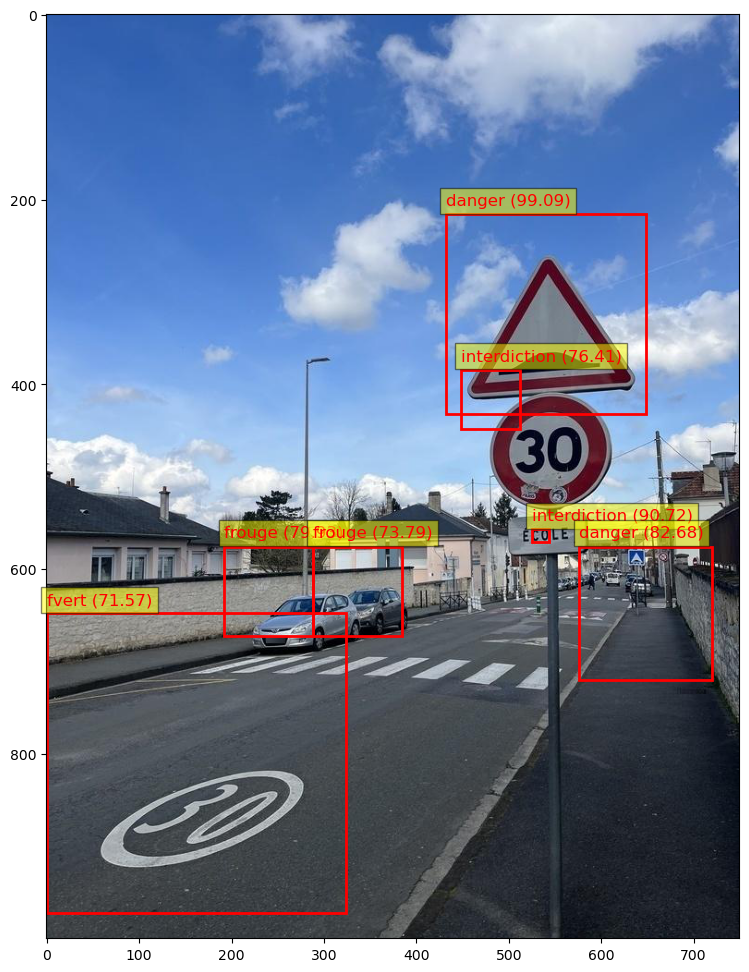

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

image_path = 'train/images/0317.jpg'
# Assurez-vous que `clf` et `label_encoder` sont déjà entraînés et disponibles
predictions = main(image_path, clf, label_encoder)

# Filtrer les prédictions individuelles
individual_predictions = [pred for pred in predictions if pred.startswith("Panneau:")]

# Parse predictions
parsed_predictions = [parse_prediction(pred) for pred in individual_predictions]

# Filtrage des panneaux
panneaux_filtrés = filtrer_panneaux(parsed_predictions)
print("Prédictions filtrées :")
for i in panneaux_filtrés:
    print(i)

# Chemin du fichier CSV associé à l'image
csv_path = 'train/labels/0317.csv'
annotations = load_csv_annotations(csv_path)

# Afficher les annotations chargées
print("Annotations chargées :")
print(annotations)

# Comparer les prédictions avec les annotations
matches = compare_predictions_with_annotations(panneaux_filtrés, annotations)

# Afficher les correspondances
print("Correspondances trouvées :")
for match in matches:
    print(match)

# Afficher l'image avec les panneaux détectés
def display_detected_signs(image_path, detections):
    image = Image.open(image_path)
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)

    for detection in detections:
        label, conf, coords = detection
        (x1, y1), (x2, y2) = coords
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-10, f'{label} ({conf:.2f})', color='red', fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.show()

display_detected_signs(image_path, panneaux_filtrés)


# Dernier essai avant abandon 

In [19]:
# Fonction de détection avec une fenêtre de taille fixe
def detect_with_fixed_window(image, win_size, step_size, confidence_threshold, clf, label_encoder, allowed_labels):
    detections = []
    for (i, resized) in enumerate(pyramid_gaussian(np.array(image), downscale=1.5, max_layer=4)):
        resized_image = Image.fromarray((resized * 255).astype(np.uint8))
        boxes = list(sliding_window(resized_image, step_size, win_size))
        results = Parallel(n_jobs=-1)(delayed(detect_single_window)(resized_image, box, clf, label_encoder, confidence_threshold) for box in boxes)
        results = [r for r in results if r is not None]

        for max_proba, predicted_label, (x1, y1, x2, y2) in results:
            if predicted_label in allowed_labels:  # Filtrer les labels non autorisés
                scale_factor = 1.5 ** i
                original_x1 = int(x1 * scale_factor)
                original_y1 = int(y1 * scale_factor)
                original_x2 = int(x2 * scale_factor)
                original_y2 = int(y2 * scale_factor)
                detections.append((max_proba, predicted_label, original_x1, original_y1, original_x2, original_y2))

    # Appliquer la suppression non maximale (NMS) aux détections
    final_detections = non_max_suppression(detections, iou_threshold=0.3)

    return final_detections

def detect_signs_in_image(image_path, clf, label_encoder, confidence_threshold, win_size, allowed_labels):
    # Charger l'image
    image = Image.open(image_path).convert('RGB')

    # Détection avec des fenêtres de taille spécifiée
    detections = detect_with_fixed_window(image, win_size, win_size[1], confidence_threshold, clf, label_encoder, allowed_labels)

    # Stocker les résultats
    bboxes = []
    bboxes_confidences = defaultdict(list)

    for max_proba, predicted_label, x1, y1, x2, y2 in detections:
        bboxes.append(((x1, y1, x2, y2), predicted_label))
        bboxes_confidences[(x1, y1, x2, y2)].append(max_proba)
    
    # Filtrer les détections avec une confiance supérieure à 65%
    filtered_bboxes = [(bbox, label) for bbox, label in bboxes if max(bboxes_confidences[bbox]) >= 0.65]

    # Fusion des boîtes et reclassification
    final_bboxes_filtered = []
    for bbox, label in filtered_bboxes:
        merged = False
        for i, (existing_bbox, existing_label) in enumerate(final_bboxes_filtered):
            if existing_label == label and (does_box_enclose(existing_bbox, bbox) or does_box_enclose(bbox, existing_bbox) or are_boxes_too_close(existing_bbox, bbox)):
                # Unifier les boîtes
                unified_box = unify_boxes(existing_bbox, bbox)
                final_bboxes_filtered[i] = (unified_box, label)
                merged = True
                break
        if not merged:
            final_bboxes_filtered.append((bbox, label))

    # Refaire la classification sur les boîtes unifiées
    final_bboxes = []
    for bbox, label in final_bboxes_filtered:
        reclassified = detect_single_window(image, bbox, clf, label_encoder, confidence_threshold)
        if reclassified:
            max_proba, predicted_label, _ = reclassified
            final_bboxes.append((bbox, predicted_label, max_proba))

    # Trouver la boîte avec la plus grande valeur de prédiction
    if final_bboxes:
        best_bbox = max(final_bboxes, key=lambda item: item[2])
        best_label = best_bbox[1]
        result_phrase = f"L'image contient à priori le panneau {best_label} avec la plus grande valeur de confiance ({best_bbox[2]*100:.2f}%)."
    else:
        result_phrase = "Aucun panneau détecté avec une confiance suffisante."

    predicted_signs = list(set([label for _, label, _ in final_bboxes]))

    return predicted_signs, final_bboxes, bboxes_confidences, result_phrase

Prédictions filtrées :
Annotations chargées :
    x1   y1   x2   y2   label
0  412  158  504  395  frouge
1  420  580  454  686  frouge
Correspondances trouvées :


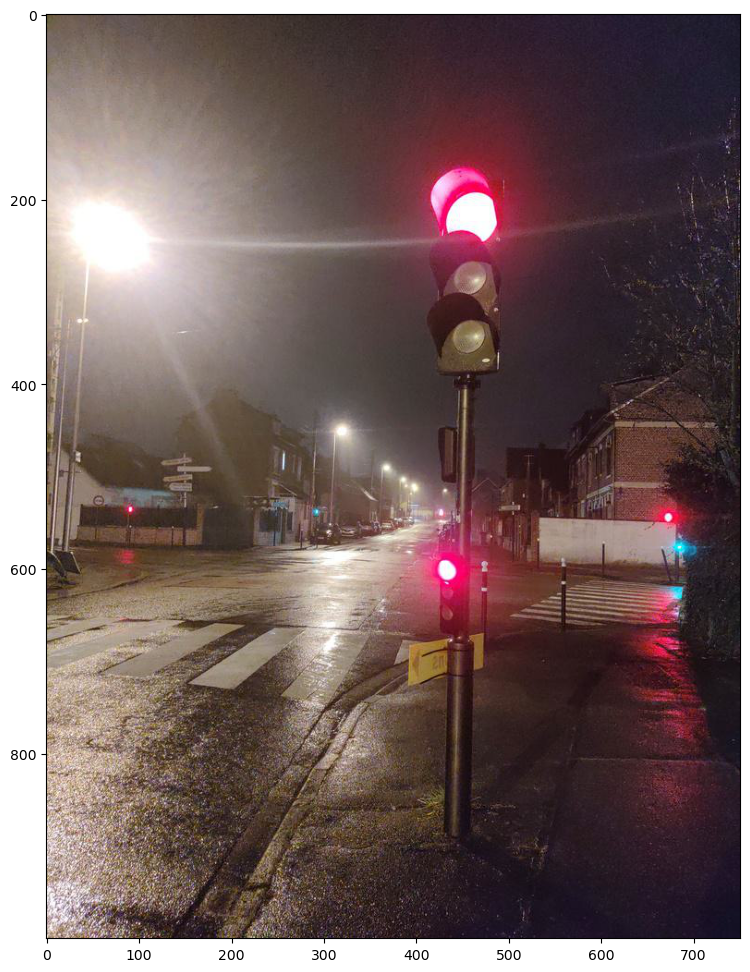

In [22]:
def main(image_path, clf, label_encoder):
    Total = []
    # Détection avec des fenêtres 64x64
    predicted_signs_64, final_bboxes_64, bboxes_confidences_64, result_phrase_64 = detect_signs_in_image(
        image_path, clf, label_encoder, confidence_threshold=0.4, win_size=(64, 64), allowed_labels=['ceder', 'danger', 'interdiction', 'obligation', 'stop'])
    
    result_phrases_64 = generate_result_phrases(final_bboxes_64, bboxes_confidences_64)
    Total.extend(result_phrases_64)

    # Détection avec des fenêtres 128x64
    predicted_signs_128, final_bboxes_128, bboxes_confidences_128, result_phrase_128 = detect_signs_in_image(
        image_path, clf, label_encoder, confidence_threshold=0.4, win_size=(64, 128), allowed_labels=['forange', 'frouge', 'fvert'])
    
    result_phrases_128 = generate_result_phrases(final_bboxes_128, bboxes_confidences_128)
    Total.extend(result_phrases_128)

    # Fusionner les résultats des deux tailles de fenêtres
    final_bboxes = final_bboxes_64 + final_bboxes_128
    bboxes_confidences = {**bboxes_confidences_64, **bboxes_confidences_128}

    result_phrase, detections = detect_and_display_shapes(image_path, clf, label_encoder)
    Total.append(result_phrase)
    
    for det in detections:
        max_proba, label, x1, y1, x2, y2 = det
        Total.append(f"Panneau: {label}, Confiance: {max_proba*100:.2f}%, Coordonnées: ({x1}, {y1}), ({x2}, {y2})")
    
    return Total

# Chemin de l'image
image_path = 'train/images/0001.jpg'
# Assurez-vous que `clf` et `label_encoder` sont déjà entraînés et disponibles
predictions = main(image_path, clf, label_encoder)

# Filtrer les prédictions individuelles
individual_predictions = [pred for pred in predictions if pred.startswith("Panneau:")]

# Parse predictions
parsed_predictions = [parse_prediction(pred) for pred in individual_predictions]

# Filtrage des panneaux
panneaux_filtrés = filtrer_panneaux(parsed_predictions)
print("Prédictions filtrées :")
for i in panneaux_filtrés:
    print(i)

# Chemin du fichier CSV associé à l'image
csv_path = 'train/labels/0001.csv'
annotations = load_csv_annotations(csv_path)

# Afficher les annotations chargées
print("Annotations chargées :")
print(annotations)

# Comparer les prédictions avec les annotations
matches = compare_predictions_with_annotations(panneaux_filtrés, annotations)

# Afficher les correspondances
print("Correspondances trouvées :")
for match in matches:
    print(match)

# Afficher l'image avec les panneaux détectés
def display_detected_signs(image_path, detections):
    image = Image.open(image_path)
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)

    for detection in detections:
        label, conf, coords = detection
        (x1, y1), (x2, y2) = coords
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-10, f'{label} ({conf:.2f})', color='red', fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.show()

display_detected_signs(image_path, panneaux_filtrés)


In [15]:
def filter_labels(detections, allowed_labels):
    """
    Filtre les détections selon les labels autorisés.
    
    Parameters:
    - detections : Liste de détections (confiance, label, x1, y1, x2, y2).
    - allowed_labels : Liste des labels autorisés.
    
    Returns:
    - Une liste filtrée de détections.
    """
    return [det for det in detections if det[1] in allowed_labels]
def detect_with_fixed_window(image, win_size, step_size, confidence_threshold, clf, label_encoder, allowed_labels):
    """
    Applique la détection avec des fenêtres de taille fixe sur une image et filtre par labels autorisés.

    Parameters:
    - image : L'image sur laquelle appliquer la détection.
    - win_size : La taille des fenêtres glissantes (largeur, hauteur).
    - step_size : La taille de pas pour chaque mouvement de fenêtre.
    - confidence_threshold : Le seuil de confiance pour les détections.
    - clf : Le classificateur SVM entraîné.
    - label_encoder : L'encodeur de labels.
    - allowed_labels : Liste des labels autorisés pour cette taille de fenêtre.

    Returns:
    - Une liste de détections filtrées (confiance, label, x1, y1, x2, y2).
    """
    detections = []
    for (i, resized) in enumerate(pyramid_gaussian(np.array(image), downscale=1.5, max_layer=4)):
        resized_image = Image.fromarray((resized * 255).astype(np.uint8))
        boxes = list(sliding_window(resized_image, step_size, win_size))
        results = Parallel(n_jobs=-1)(delayed(detect_single_window)(resized_image, box, clf, label_encoder, confidence_threshold) for box in boxes)
        results = [r for r in results if r is not None]

        for max_proba, predicted_label, (x1, y1, x2, y2) in results:
            scale_factor = 1.5 ** i
            original_x1 = int(x1 * scale_factor)
            original_y1 = int(y1 * scale_factor)
            original_x2 = int(x2 * scale_factor)
            original_y2 = int(y2 * scale_factor)
            detections.append((max_proba, predicted_label, original_x1, original_y1, original_x2, original_y2))

    detections = filter_labels(detections, allowed_labels)
    final_detections = non_max_suppression(detections, iou_threshold=0.3)

    return final_detections
def detect_signs_in_image(image_path, clf, label_encoder, confidence_threshold=0.4):
    """
    Détecte les panneaux de signalisation dans une image en utilisant deux tailles de fenêtres glissantes et filtre par labels autorisés.

    Parameters:
    - image_path : Chemin de l'image à analyser.
    - clf : Le classificateur SVM entraîné.
    - label_encoder : L'encodeur de labels.
    - confidence_threshold : Le seuil de confiance pour les détections.

    Returns:
    - Liste des panneaux détectés.
    - Liste des boîtes englobantes finales.
    - Dictionnaire des confiances associées aux boîtes.
    - Phrase résumant le résultat de la détection.
    """
    image = Image.open(image_path).convert('RGB')

    # Détection avec des fenêtres 64x64
    labels_64x64 = ['ceder', 'danger', 'interdiction', 'obligation', 'stop']
    detections_64x64 = detect_with_fixed_window(image, (64, 64), 64, confidence_threshold, clf, label_encoder, labels_64x64)

    # Détection avec des fenêtres 128x64
    labels_128x64 = ['forange', 'frouge', 'fvert']
    detections_128x64 = detect_with_fixed_window(image, (128, 64), 64, confidence_threshold, clf, label_encoder, labels_128x64)

    # Combiner les détections
    detections = detections_64x64 + detections_128x64

    # Stocker les résultats
    bboxes = []
    bboxes_confidences = defaultdict(list)

    for max_proba, predicted_label, x1, y1, x2, y2 in detections:
        bboxes.append(((x1, y1, x2, y2), predicted_label))
        bboxes_confidences[(x1, y1, x2, y2)].append(max_proba)

    # Filtrer les détections avec une confiance supérieure à 65%
    filtered_bboxes = [(bbox, label) for bbox, label in bboxes if max(bboxes_confidences[bbox]) >= 0.65]

    # Fusion des boîtes et reclassification
    final_bboxes_filtered = []
    for bbox, label in filtered_bboxes:
        merged = False
        for i, (existing_bbox, existing_label) in enumerate(final_bboxes_filtered):
            if existing_label == label and (does_box_enclose(existing_bbox, bbox) or does_box_enclose(bbox, existing_bbox) or are_boxes_too_close(existing_bbox, bbox)):
                unified_box = unify_boxes(existing_bbox, bbox)
                final_bboxes_filtered[i] = (unified_box, label)
                merged = True
                break
        if not merged:
            final_bboxes_filtered.append((bbox, label))

    # Refaire la classification sur les boîtes unifiées
    final_bboxes = []
    for bbox, label in final_bboxes_filtered:
        reclassified = detect_single_window(image, bbox, clf, label_encoder, confidence_threshold)
        if reclassified:
            max_proba, predicted_label, _ = reclassified
            final_bboxes.append((bbox, predicted_label, max_proba))

    # Trouver la boîte avec la plus grande valeur de prédiction
    if final_bboxes:
        best_bbox = max(final_bboxes, key=lambda item: item[2])
        best_label = best_bbox[1]
        result_phrase = f"L'image contient à priori le panneau {best_label} avec la plus grande valeur de confiance ({best_bbox[2]*100:.2f}%)."
    else:
        result_phrase = "Aucun panneau détecté avec une confiance suffisante."

    predicted_signs = list(set([label for _, label, _ in final_bboxes]))

    return predicted_signs, final_bboxes, bboxes_confidences, result_phrase


Prédictions filtrées :
Annotations chargées :
    x1   y1   x2   y2   label
0  412  158  504  395  frouge
1  420  580  454  686  frouge
Correspondances trouvées :


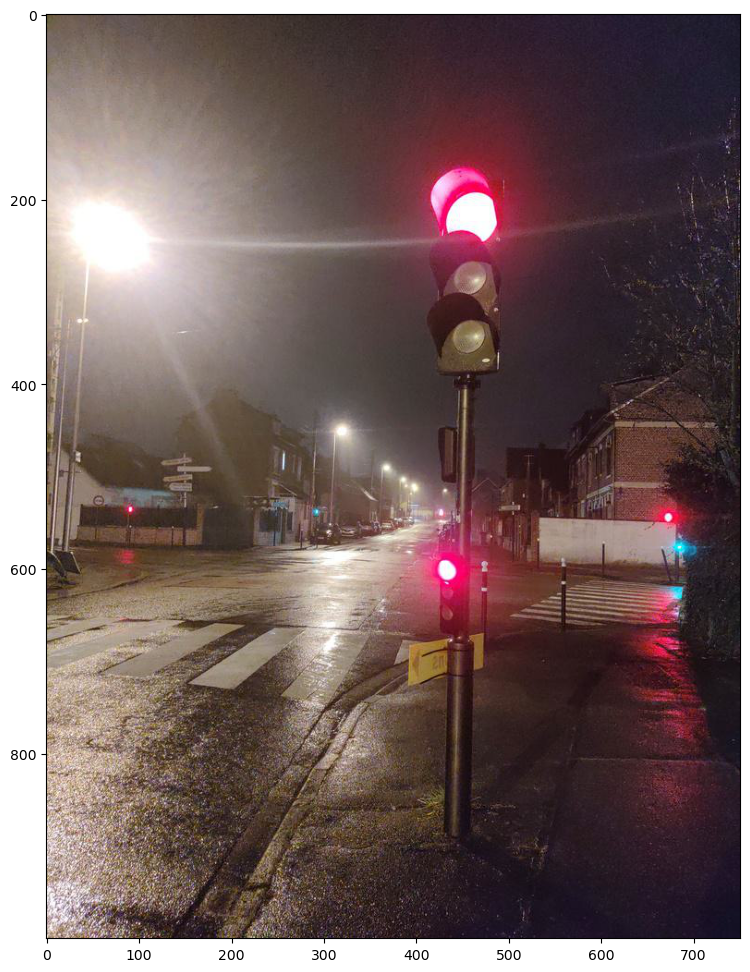

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def main(image_path, clf, label_encoder):
    Total = []
    predicted_signs, final_bboxes, bboxes_confidences, result_phrase = detect_signs_in_image(image_path, clf, label_encoder)
    result_phrases = generate_result_phrases(final_bboxes, bboxes_confidences)
    Total.extend(result_phrases)

    result_phrase, detections = detect_and_display_shapes(image_path, clf, label_encoder)
    Total.append(result_phrase)
    
    for det in detections:
        max_proba, label, x1, y1, x2, y2 = det
        Total.append(f"Panneau: {label}, Confiance: {max_proba*100:.2f}%, Coordonnées: ({x1}, {y1}), ({x2}, {y2})")
    
    return Total

# Chemin de l'image et du fichier CSV associé
image_path = 'train/images/0001.jpg'
csv_path = 'train/labels/0001.csv'

# Assurez-vous que `clf` et `label_encoder` sont déjà entraînés et disponibles
predictions = main(image_path, clf, label_encoder)

# Filtrer les prédictions individuelles
individual_predictions = [pred for pred in predictions if pred.startswith("Panneau:")]

# Parse predictions
parsed_predictions = [parse_prediction(pred) for pred in individual_predictions]

# Filtrage des panneaux
panneaux_filtrés = filtrer_panneaux(parsed_predictions)
print("Prédictions filtrées :")
for i in panneaux_filtrés:
    print(i)

# Charger les annotations depuis le fichier CSV
annotations = load_csv_annotations(csv_path)

# Afficher les annotations chargées
print("Annotations chargées :")
print(annotations)

# Comparer les prédictions avec les annotations
matches = compare_predictions_with_annotations(panneaux_filtrés, annotations)

# Afficher les correspondances
print("Correspondances trouvées :")
for match in matches:
    print(match)

# Afficher l'image avec les panneaux détectés
def display_detected_signs(image_path, detections):
    image = Image.open(image_path)
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)

    for detection in detections:
        label, conf, coords = detection
        (x1, y1), (x2, y2) = coords
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-10, f'{label} ({conf:.2f})', color='red', fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.show()

display_detected_signs(image_path, panneaux_filtrés)
